In [2]:
""" import useful functions """

import os

# Generic
import pandas as pd
import numpy as np
import scipy
from itertools import islice, cycle
import math
import sys
from scipy.integrate import odeint
from joblib import Parallel, delayed
import itertools
from importlib import reload
from functools import lru_cache
import scipy.integrate

# cosmology
import pyccl as ccl
from astropy.io import fits
import yaml
import sacc
import time

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# SRD Binning
import srd_redshift_distributions as srd
import binning

# Data Visualization
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
#import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from chainconsumer import ChainConsumer, Chain, make_sample
from IPython.display import display, Math
from multiprocessing import Pool
from tqdm import tqdm

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor

# f(R) emu (eMANTIS)
from emantis import FofrBoost

In [3]:
from LikelihoodFuncts_PCADR_muSigma import *

Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# Define cosmology
cosmo_universe = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9)


fR_universe = 1e-5
H0rc_universe = 0.0
MGParam_universe = [H0rc_universe,fR_universe,0,0,0]

In [5]:
#### Run to get the data and covariance (with scale cuts) to put into the likelihood function
command = 'python Get_Data_3x2pt_fsigma8_fR.py --OmgC {} --OmgB {} --h {} --ns {} --As {}'.format(cosmo_universe["Omega_c"],cosmo_universe["Omega_b"],cosmo_universe["h"], cosmo_universe["n_s"],cosmo_universe["A_s"])
os.system(command)


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data
starting code
collecting data
Training the emulator at aexp=0.3333... done.
Training the emulator at aexp=0.3650... done.
Training the emulator at aexp=0.4000... done.
Training the emulator at aexp=0.4167... done.
Training the emulator at aexp=0.4444... done.
Training the emulator at aexp=0.4762... done.
Training the emulator at aexp=0.5000... done.
Training the emulator at aexp=0.5263... done.
Training the emulator at aexp=0.5556... done.
Training the emulator at aexp=0.5882... done.
Training the emulator at aexp=0.6250... done.
Training the emulator at aexp=0.6667... done.
Training the emulator at aexp=0.7042... done.
Training the emulator at aexp=0.7692... done.
Training the emulator at aexp=0.8000... done.
Training the emulator at aexp=0.8696... done.
Training the emulator at aexp=0.9091... done.
Training the emulator at aexp=0.9524... done.
Training the emulator at aexp=1.0000... done.
No scale cuts - we are using GR cuts


0

In [7]:
### Load and collect the data for likelihood
#npzfile = np.load("../Biases_parametrization/Data_storage_fR.npz")
npzfile = np.load("Data_storage_fR_partial.npz")
npzfile_GR = np.load("../Parameter_inference_GR/Data_storage_GR.npz")

C_ell_data_mock = [npzfile['C_ell_data'],npzfile['ell_data'],npzfile['z'],npzfile['Binned_distribution_source'],\
                    npzfile['Binned_distribution_lens'],20,1478.5,13]

Data_fsigma8= [npzfile['z_eff_fsigma8'], npzfile['fsigma8_data'],np.matrix(npzfile['invcov_fsigma8'])]

L_choleski_inv = np.matrix(npzfile_GR['L_ch_inv'])

gauss_invcov_rotated = np.matrix(npzfile_GR['Inverse_cov'])

## Plot to check data/covariance

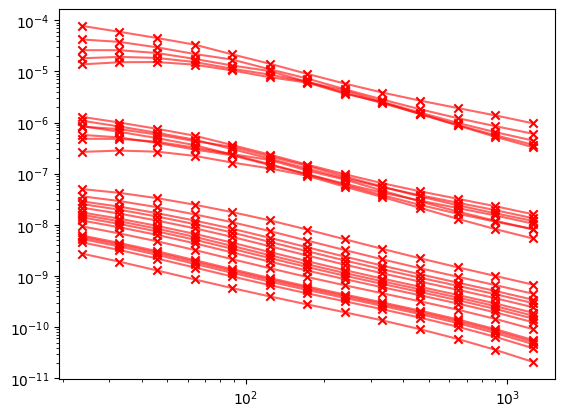

In [8]:
## Plot to check 3x2pt data

plt.scatter(C_ell_data_mock[1],C_ell_data_mock[0], color="r", marker='x')

for j in range(27):
    plt.plot(C_ell_data_mock[1][j*13:(j+1)*13], C_ell_data_mock[0][j*13:(j+1)*13], "r", alpha=0.6)

plt.xscale("log")
plt.yscale("log")

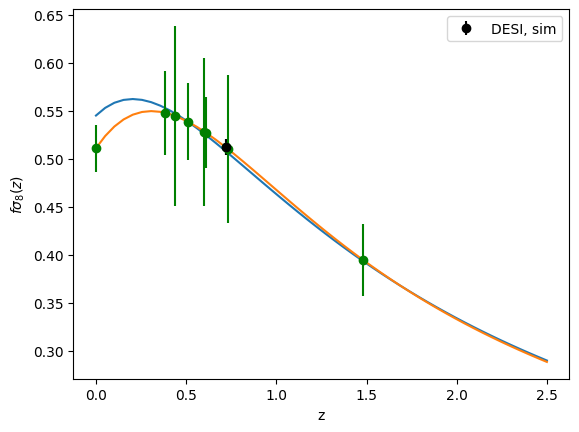

In [9]:
## Plot to check fsigma8 data
P_delta2D_GR_lin_universe = Get_Pk2D_obj_kk_GR_lin(cosmo_universe)

# GET F(R) LINEAR POWER SPECTRUM, universe
##########################
idx_mdom = 0
a_solver = np.linspace(1/50,1.1,50)
k_solver = np.logspace(-5,4,200)

Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo_universe, a_solver[0])*a_solver[0]**3)], a_solver,\
              args=(cosmo_universe,[0,0,0,0,0]), mxstep=int(1e4))

Delta_GR = Soln.T[0]/Soln.T[0][idx_mdom]

Delta = []
for i in range(len(k_solver)):
    Soln = odeint(solverGrowth_fR, [a_solver[0], (E(cosmo_universe, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo_universe,MGParam_universe, k_solver[i]), mxstep=int(1e4))
    
    Delta_i = Soln.T[0]
    Delta.append(Delta_i/Delta_i[idx_mdom])

Delta = np.array(Delta)

# Get Pk linear in GR

interp_fR_Pk_universe = scipy.interpolate.RegularGridInterpolator((k_solver,a_solver), (Delta / Delta_GR)**2,bounds_error=False, fill_value=1.0)
##########################

plt.plot(np.linspace(0.0, 2.5, 50), fsigma8_musigma(P_delta2D_GR_lin_universe,cosmo_universe, [0,0,0,0.3,0.2], 1/(np.linspace(0.0, 2.5, 50)+1)))
plt.plot(np.linspace(0.0, 2.5, 50), fsigma8_fR(P_delta2D_GR_lin_universe,interp_fR_Pk_universe, cosmo_universe, MGParam_universe, 1/(np.linspace(0.0, 2.5, 50)+1)))
#plt.errorbar(Data_fsigma8[0][:-1], fsigma_8_realdata, yerr=fsigma_8_realdata*fsigma_8_fracerror[:-1], fmt="o", color="r")
plt.errorbar(Data_fsigma8[0], Data_fsigma8[1], yerr=np.sqrt(np.diag(np.linalg.inv(Data_fsigma8[2]))), fmt="o", color="g")
plt.errorbar(Data_fsigma8[0][-1], Data_fsigma8[1][-1], yerr=np.sqrt(np.diag(np.linalg.inv(Data_fsigma8[2])))[-1], fmt="o", color="k", label = "DESI, sim")


plt.xlabel("z")
plt.ylabel(r"$f \sigma_8(z)$")
plt.legend()

87


/home/c2042999/PCA_project/Parameter_inference_fR/LikelihoodFuncts_PCADR_muSigma.py:1486: RuntimeWarning: invalid value encountered in divide
  return cov/np.outer(sig, sig)


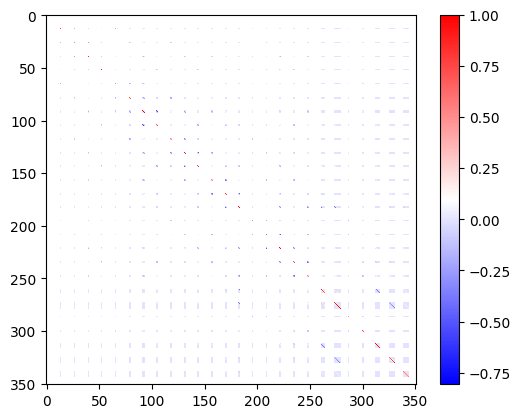

In [10]:
## Plot correlation matrix (scale cuts)

plt.imshow(cov2corr(gauss_invcov_rotated), origin='upper',  cmap='bwr')

print(np.sum(np.any(gauss_invcov_rotated != 0, axis=1)))
plt.colorbar()
plt.show()

(351, 351)
254


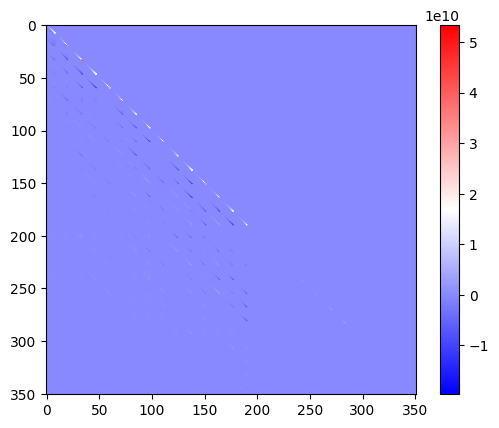

In [11]:
## Plot to choleski matrix (scale cuts)

print(L_choleski_inv.shape)
plt.imshow((L_choleski_inv), origin='upper',  cmap='bwr')
print(np.sum(np.any(L_choleski_inv != 0, axis=1)))

plt.colorbar()
plt.show()

(351, 351)


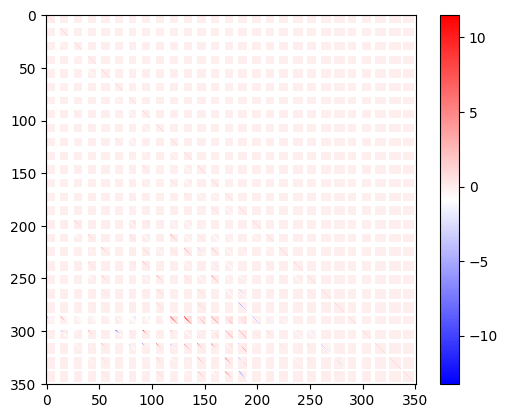

In [12]:
print(L_choleski_inv.shape)
plt.imshow(cov2corr(L_choleski_inv), origin='upper',  cmap='bwr')

plt.colorbar()
plt.show()